In [11]:
# imports


#import json
#import tensorflow
#import concurrent.futures
#from datasets import load_dataset
#from resnet import ResNet152, ResNet50


from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from transformers import AutoImageProcessor, ResNetForImageClassification
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
import torch
import torch.nn as nn
import torch_directml as dml
import torch.optim as optim
import math
import copy
import os
import cv2
import time
import shutil
import random
import psutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
def analyze_image_filenames(image_dir, sample_size=500):
    """Analyze image filename patterns to understand their structure"""
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print("No image files found in directory!")
        return []

    sample = random.sample(image_files, min(sample_size, len(image_files)))
    
    print(f"\nAnalyzing {len(sample)} sample image filenames:")
    for filename in sample:
        print(f"  - {filename}")
    
    # Try to identify patterns
    separators = ['_', '-', ' ']
    for sep in separators:
        has_separator = any(sep in filename for filename in sample)
        if has_separator:
            print(f"\nFound separator '{sep}' in filenames")
            parts_counts = [len(f.split(sep)) for f in sample if sep in f]
            if parts_counts:
                print(f"  Average parts when split by '{sep}': {sum(parts_counts)/len(parts_counts):.1f}")
    
    return image_files

# Run the analysis
image_files = analyze_image_filenames("./images/cars2")


Analyzing 500 sample image filenames:
  - Shelby car back_Shelby_car_back_10.jpg
  - Toyota_Tacoma_2014_21_15_150_27_4_72_66_208_19_RWD_4_4_Pickup_obW.jpg
  - Porsche_Panamera_2020_103_21_330_30_6_76_56_198_19_RWD_4_4_4dr_uKd.jpg
  - Volvo_S90_2019_49_18_250_20_4_74_57_200_22_AWD_5_4_4dr_XAR.jpg
  - GMC_Sierra 1500_2013_46_20_400_62_8_80_73_nan_13_RWD_5_4_Pickup_TRX.jpg
  - Jeep_Cherokee_2016_27_18_180_24_4_73_66_nan_21_4WD_5_4_SUV_ajv.jpg
  - Kia_Sportage_2017_27_18_180_24_4_73_65_176_21_AWD_5_4_SUV_sdE.jpg
  - Porsche_718_2017_56_18_300_20_4_70_50_172_21_RWD_2_2_Convertible_iQF.jpg
  - Hyundai_Sonata_2019_23_16_170_16_4_73_58_191_28_FWD_5_4_4dr_vgH.jpg
  - Mazda_CX-3_2016_26_18_140_20_4_69_60_168_27_AWD_5_4_SUV_uCQ.jpg
  - Audi_A7_2019_68_19_330_30_6_75_56_195_22_AWD_5_4_4dr_BSs.jpg
  - Buick car back_Buick_car_back_25.jpg
  - Ford_Fusion_2014_21_16_170_25_4_72_58_191_22_FWD_5_4_4dr_Nli.jpg
  - smart car back_smart_car_back_51.jpg
  - Volkswagen_Golf_2015_20_15_170_18_4_70_57_167_25

In [13]:
# Load combined_cars.csv
csv_path = './processed_data/combined_cars.csv'
combined_cars_df = pd.read_csv(csv_path)

# Create class labels from Make and Model
combined_cars_df['Class'] = combined_cars_df['Make'] # + ' ' + combined_cars_df['Model']
class_names = combined_cars_df['Class'].unique().tolist()
class_names.append('other')  # Add 'other' for non-car images
print(f"Class names: {class_names}")
len(class_names)


Class names: ['Chevrolet', 'Ford', 'Hyundai', 'Volkswagen', 'Honda', 'Maruti', 'BMW', 'Mahindra', 'Tata', 'Fiat', 'Cars Movie', 'Toyota', 'Nissan', 'Volvo', 'Ambassador', 'Skoda', 'Audi', 'Datsun', 'Renault', 'OpelCorsa', 'Kia', 'Mercedes-Benz', 'Mitsubishi', 'MG', 'Land', 'Jeep', 'Jaguar', 'Isuzu', 'Force', 'Daewoo', 'Lexus', 'Infiniti', 'Land Rover', 'Lincoln', 'Lotus', 'Chrysler', 'Maserati', 'Cadillac', 'Rolls-Royce', 'Oldsmobile', 'GMC', 'Alfa Romeo', 'Buick', 'Mercury', 'Dodge', 'Laforza Automobile Inc', 'Suzuki', 'Mazda', 'Porsche', 'Aston Martin', 'Acura', 'MINI', 'Rivian', 'Pontiac', 'Spyker', 'Tecstar, LP', 'Bentley', 'Saturn', 'Dacia', 'Lamborghini', 'Roush Performance', 'Tesla', 'CX Automotive', 'Subaru', 'Lucid', 'Ferrari', 'Vinfast', 'Genesis', 'Koenigsegg', 'McLaren Automotive', 'Plymouth', 'Federal Coach', 'Vector', 'Geo', 'Kenyon Corporation Of America', 'Scion', 'smart', 'Ram', 'Bugatti', 'Wallace Environmental', 'J.K. Motors', 'Maybach', 'Volga Associated Automobile'

160

Using top 159 makes as classes


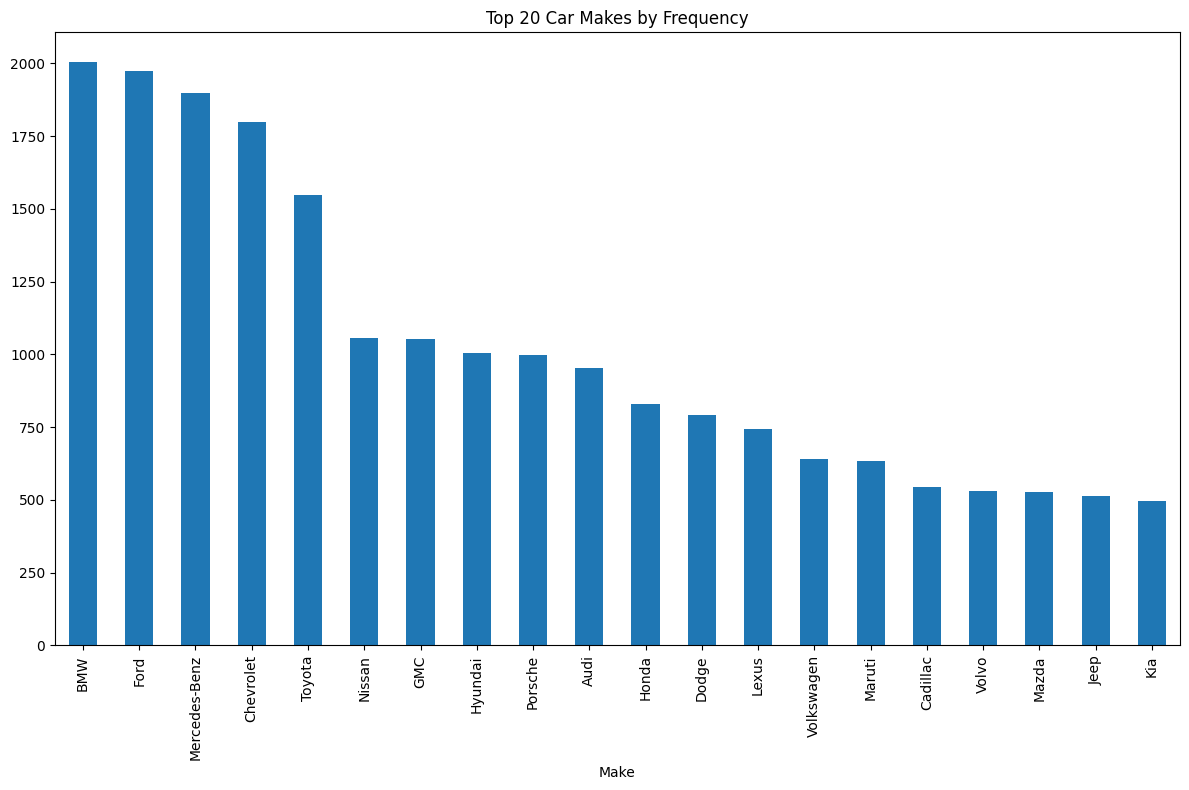

In [21]:
# Count frequency of each make to identify the most common ones
make_counts = combined_cars_df['Make'].value_counts()

# Plot distribution of makes
plt.figure(figsize=(12, 8))
make_counts.head(20).plot(kind='bar')
plt.title('Top 20 Car Makes by Frequency')
plt.tight_layout()

# Select top N makes to keep number of classes manageable
N = 159  # Your target number of classes
top_makes = make_counts.head(N).index.tolist()
print(f"Using top {len(top_makes)} makes as classes")

In [17]:
# Preparation of the images & datasets


def process_image(args):
    i, img_file, source_dir, output_dir, top_makes, train_end, valid_end = args
    try:
        # Determine split
        if i < train_end:
            split = 'train'
        elif i < valid_end:
            split = 'valid'
        else:
            split = 'test'

        # Source path
        src_path = os.path.join(source_dir, img_file)
        
        # Determine class label based on filename
        img_file_lower = img_file.lower()
        img_class = 'other'  # Default class
        
        for make in top_makes:
            # Simple string matching
            if make.lower() in img_file_lower:
                img_class = make
                break
        
        # Replace spaces with underscores for directory names
        class_dir_name = img_class.replace(' ', '_')
        
        # Destination directory
        dst_dir = os.path.join(output_dir, split, class_dir_name)
        
        # Resize and save the image
        img = cv2.imread(src_path)
        if img is None:
            return f"Warning: Could not read image {src_path}"
            
        # Use INTER_AREA for downsampling
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        dst_path = os.path.join(dst_dir, img_file)
        cv2.imwrite(dst_path, img_resized)
        
        return None  # No error
        
    except Exception as e:
        return f"Error processing {img_file}: {str(e)}"


def prepare_dataset_sequential(source_dir, output_dir='./data', top_makes=None, 
                           sample_size=77528, train_split=0.7, valid_split=0.15):
    """
    Prepare a dataset with class labels based on top car makes (sequential version).
    """

    # Create output directories
    for split_dir in [os.path.join(output_dir, split) for split in ['train', 'valid', 'test']]:
        if os.path.exists(split_dir):
            shutil.rmtree(split_dir)
        os.makedirs(split_dir, exist_ok=True)
    
    # Get all images
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)

    # Limit to sample size
    image_files = image_files[:sample_size]
    print(f"Using {len(image_files)} images (from total {len(os.listdir(source_dir))})")

    # Calculate split indices
    train_end = int(len(image_files) * train_split)
    valid_end = train_end + int(len(image_files) * valid_split)
    
    # Track which classes have been found in images
    found_classes = set()
    
    # First pass: identify which classes are actually present in the dataset
    print("Scanning images to identify classes...")
    for img_file in tqdm(image_files, desc="Identifying classes"):
        img_file_lower = img_file.lower()
        for make in top_makes:
            if make.lower() in img_file_lower:
                found_classes.add(make)
                break
    
    # Add 'other' class if needed
    found_classes.add('other')  # Always include 'other' class
    
    print(f"Found {len(found_classes)} classes in the dataset")
    
    # Create only directories for classes that exist
    for split in ['train', 'valid', 'test']:
        for make in found_classes:
            safe_make = make.replace(' ', '_')
            os.makedirs(os.path.join(output_dir, split, safe_make), exist_ok=True)
    
    # Process images sequentially with tqdm progress bar
    errors = []
    class_distribution = {make: 0 for make in found_classes}
    
    for i, img_file in tqdm(enumerate(image_files), total=len(image_files), desc="Processing images"):
        try:
            # Determine split
            if i < train_end:
                split = 'train'
            elif i < valid_end:
                split = 'valid'
            else:
                split = 'test'

            # Source path
            src_path = os.path.join(source_dir, img_file)
            
            # Determine class label based on filename
            img_file_lower = img_file.lower()
            img_class = 'other'  # Default class
            
            for make in found_classes:
                if make != 'other' and make.lower() in img_file_lower:
                    img_class = make
                    break
            
            # Replace spaces with underscores for directory names
            class_dir_name = img_class.replace(' ', '_')
            
            # Destination directory
            dst_dir = os.path.join(output_dir, split, class_dir_name)
            
            # Resize and save the image
            img = cv2.imread(src_path)
            if img is None:
                errors.append(f"Warning: Could not read image {src_path}")
                continue
                
            img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
            dst_path = os.path.join(dst_dir, img_file)
            cv2.imwrite(dst_path, img_resized)
            
            # Update class distribution counter
            class_distribution[img_class] += 1
            
        except Exception as e:
            errors.append(f"Error processing {img_file}: {str(e)}")
    
    # Print errors if any
    if errors:
        print("\nErrors encountered:")
        for error in errors:
            print(error)
    
    # Print class distribution
    print("\nClass distribution:")
    for make, count in sorted(class_distribution.items(), key=lambda x: x[1], reverse=True):
        print(f"{make}: {count} images")
    
    # Check for empty classes again (shouldn't happen with our new approach)
    empty_classes = [make for make, count in class_distribution.items() if count == 0]
    if empty_classes:
        print(f"\nWarning: {len(empty_classes)} empty classes detected.")
        print(f"Empty classes: {empty_classes}")
        
        # Remove empty class directories to prevent errors
        for split in ['train', 'valid', 'test']:
            for empty_class in empty_classes:
                empty_dir = os.path.join(output_dir, split, empty_class.replace(' ', '_'))
                if os.path.exists(empty_dir):
                    shutil.rmtree(empty_dir)
                    print(f"Removed empty directory: {empty_dir}")

    print("\nDataset preparation complete.")
    
    # Return only class names that have images
    return [make.replace(' ', '_') for make in found_classes if class_distribution[make] > 0]


def filter_out_other_class(base_dir):
    """
    Remove the 'other' class folder from all dataset splits
    """
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(base_dir, split, 'other')
        if os.path.exists(other_dir):
            print(f"Removing 'other' class from {split} split")
            shutil.rmtree(other_dir)
            print(f"Removed: {other_dir}")
        else:
            print(f"No 'other' class found in {split} split")
    
    print("Removed 'other' class from all dataset splits")
    
    
# Modified dataset loading code with error handling
def create_image_datasets(base_dir, data_transforms):
    """Create image datasets with error handling for empty class directories"""
    datasets_dict = {}
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        # Get list of non-empty class directories
        valid_classes = []
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                # Check if directory has at least one valid image
                valid_files = [f for f in os.listdir(class_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if valid_files:
                    valid_classes.append(class_name)
                else:
                    # Remove empty directory to avoid future errors
                    print(f"Removing empty class directory: {class_dir}")
                    shutil.rmtree(class_dir)
        
        print(f"Found {len(valid_classes)} valid classes in {split} split")
        
        # Create dataset with only valid classes
        try:
            datasets_dict[split] = datasets.ImageFolder(split_dir, transform=data_transforms[split])
        except Exception as e:
            print(f"Error loading {split} dataset: {str(e)}")
            # Create empty dataset as fallback
            datasets_dict[split] = None
    
    return datasets_dict


In [18]:
# Unfreezing layers

# Progressive unfreezing function
# non torchvision model
# def unfreeze_layers(model, num_layers):
#     """Unfreeze the last n layers of the model"""
#     trainable_layers = []
#     for name, param in model.named_parameters():
#         if 'classifier' in name:
#             param.requires_grad = True
#             trainable_layers.append(name)
#         elif 'bn' in name or 'batchnorm' in name or 'norm' in name:
#             param.requires_grad = True
#             trainable_layers.append(name)
    
#     # Count parameters in model.resnet (excluding classifier)
#     resnet_layers = []
#     for name, param in model.resnet.named_parameters():
#         resnet_layers.append(name)
    
#     # Reverse so we unfreeze from the end first
#     resnet_layers.reverse()
    
#     # Unfreeze the specified number of layers
#     unfrozen = 0
#     for name in resnet_layers:
#         if unfrozen >= num_layers:
#             break
#         param = model.resnet.get_parameter(name)
#         param.requires_grad = True
#         trainable_layers.append('resnet.' + name)
#         unfrozen += 1
        
#     print(f"Unfrozen {len(trainable_layers)} layers in total")
#     return trainable_layers


def unfreeze_layers(model, num_blocks):
    """Unfreeze blocks of ResNet model starting from the end"""
    # First freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    trainable_layers = []
    
    # Always unfreeze fully connected layer (classifier)
    for name, param in model.fc.named_parameters():
        param.requires_grad = True
        trainable_layers.append(f"fc.{name}")
    
    # Define blocks to unfreeze in order (from last to first)
    if num_blocks > 0:
        blocks_to_unfreeze = []
        
        # Add layer4 (last block)
        if num_blocks >= 1:
            blocks_to_unfreeze.append('layer4')
        
        # Add layer3
        if num_blocks >= 2:
            blocks_to_unfreeze.append('layer3')
        
        # Add layer2
        if num_blocks >= 3:
            blocks_to_unfreeze.append('layer2')
        
        # Add layer1
        if num_blocks >= 4:
            blocks_to_unfreeze.append('layer1')
        
        # Unfreeze the selected blocks
        for block_name in blocks_to_unfreeze:
            block = getattr(model, block_name)
            for name, param in block.named_parameters():
                param.requires_grad = True
                trainable_layers.append(f"{block_name}.{name}")
    
    print(f"Unfrozen {len(trainable_layers)} layers in total")
    return trainable_layers

In [19]:
# GPU & Memory-related functions


def check_gpu_utilization():
    """Monitor GPU usage the best we can with DirectML"""
    try:
        print("\nGPU Metrics:")
        # Get process memory info as a proxy
        process = psutil.Process(os.getpid())
        print(f"Process memory usage: {process.memory_info().rss / 1024**2:.2f} MB")
        print("Note: DirectML doesn't expose detailed GPU metrics")
    except Exception as e:
        print(f"Error getting metrics: {str(e)}")
       
        
def aggressive_memory_cleanup():
    """Aggressively clean up memory"""
    import gc
    
    # Force garbage collection
    gc.collect()
    
    # Clear DirectML cache if possible
    if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
        torch.directml.empty_cache()
        print("Cleared DirectML cache")


def memory_efficient_forward(model, inputs, max_retries=3):
    """Better OOM handling for forward pass"""
    batch_size = inputs.shape[0]
    
    # First try: normal forward pass with full batch
    try:
        return model(inputs)
    except RuntimeError as e:
        # If OOM, try to split the batch
        if "out of memory" in str(e) or "not enough GPU" in str(e):
            print(f"OOM with batch size {batch_size}, trying to split batch...")
            
            # Clear cache immediately
            if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
                torch.directml.empty_cache()
            
            # If batch size is already 1, we can't reduce further
            if batch_size <= 1:
                print("Cannot split batch further, minimum batch size reached")
                raise e
                
            # Try with half the batch size
            half = batch_size // 2
            try:
                # Process first half
                out1 = model(inputs[:half])
                # Process second half
                out2 = model(inputs[half:])
                
                # Combine results (assuming the model output has logits)
                if hasattr(out1, 'logits'):
                    combined_logits = torch.cat([out1.logits, out2.logits], dim=0)
                    # Create a new output object with combined logits
                    from transformers.modeling_outputs import ImageClassifierOutput
                    return ImageClassifierOutput(logits=combined_logits)
                else:
                    # For plain tensors
                    return torch.cat([out1, out2], dim=0)
            except RuntimeError:
                print("Still OOM after splitting batch. Please reduce batch size further.")
                raise
        else:
            # Not an OOM error
            raise e



In [24]:
# Training functions for the ResNet Model


# Configure DirectML
dml_device = dml.device(dml.default_device())
print(f"Using DirectML device: {dml.device_name(dml.default_device())}")

# Define paths
#source_dir = './images/cars'  # Source directory containing all images
source_dir = './images/cars2'
data_dir = './data'  # Output directory for train, valid, and test splits
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Initialize "variable" connection with the GPU
device = dml_device

torch.backends.cudnn.benchmark = True  # Speed up training

# Use the function
class_names = prepare_dataset_sequential(
    source_dir='./images/cars2',
    output_dir='./data',
    top_makes=top_makes,
    sample_size=77528 # Adjust based on your available images
)

Using DirectML device: AMD  Radeon RX 7800 XT 
Using 77528 images (from total 77528)
Scanning images to identify classes...


Identifying classes: 100%|██████████| 77528/77528 [00:00<00:00, 588759.51it/s]


Found 95 classes in the dataset


Processing images: 100%|██████████| 77528/77528 [09:25<00:00, 137.17it/s]


Errors encountered:

Class distribution:
Chevrolet: 5264 images
Toyota: 4721 images
Ford: 4542 images
BMW: 4353 images
Nissan: 4011 images
Audi: 3259 images
Mercedes-Benz: 3206 images
Honda: 2789 images
Kia: 2292 images
Lexus: 2252 images
Hyundai: 2209 images
GMC: 2186 images
Volkswagen: 1878 images
Subaru: 1735 images
Mazda: 1598 images
Dodge: 1472 images
Porsche: 1461 images
Lincoln: 1449 images
Cadillac: 1438 images
Volvo: 1349 images
Jeep: 1320 images
Acura: 1300 images
MINI: 1221 images
Jaguar: 1188 images
Infiniti: 1177 images
Buick: 1089 images
Land Rover: 1087 images
Fiat: 1021 images
Ram: 875 images
Aston: 833 images
Bentley: 827 images
Mitsubishi: 774 images
Chrysler: 699 images
Maserati: 577 images
Alfa: 546 images
smart: 514 images
Rolls-Royce: 405 images
Lamborghini: 378 images
other: 326 images
MG: 321 images
Tesla: 321 images
Genesis: 305 images
Geo: 246 images
Ferrari: 221 images
McLaren: 202 images
Hummer: 187 images
London Taxi: 159 images
STI: 133 images
SRT: 132 im

In [ ]:
# Training functions regarding the model



def pseudo_label_other_images(model, data_dir, class_names, device, transforms, confidence_threshold=0.5, max_samples=3000):
    """
    Generate pseudo-labels for images in the 'other' class with more aggressive parameters.
    
    Args:
        model: Trained model to use for predictions
        data_dir: Base data directory
        class_names: List of class names
        device: Device to run model on
        transforms: Image transformations to apply
        confidence_threshold: Threshold to consider a prediction valid (lower = more aggressive)
        max_samples: Maximum number of samples to process from 'other' class (higher = more aggressive)
    """
    print("\nGenerating pseudo-labels for 'other' class images...")
    model.eval()
    
    moved_images = {split: 0 for split in ['train', 'valid', 'test']}
    total_other_images = {split: 0 for split in ['train', 'valid', 'test']}
    
    # Find 'other' class index to avoid labeling as 'other'
    other_idx = -1
    for i, cls in enumerate(class_names):
        if cls == 'other':
            other_idx = i
            break
    
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(data_dir, split, 'other')
        if not os.path.exists(other_dir):
            continue
            
        other_images = [f for f in os.listdir(other_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_other_images[split] = len(other_images)
        
        if not other_images:
            continue
        
        # Process more images than before - more aggressive sampling
        if split == 'train' and len(other_images) > max_samples:
            sample_size = min(max_samples, len(other_images))
            other_images = random.sample(other_images, sample_size)
            print(f"Processing {sample_size} sampled images from {split}/other (from total {total_other_images[split]})")
        else:
            print(f"Processing {len(other_images)} images from {split}/other")
        
        # Process each image
        for img_file in tqdm(other_images, desc=f"Pseudo-labeling {split}/other"):
            img_path = os.path.join(other_dir, img_file)
            
            # Load and preprocess the image
            try:
                image = Image.open(img_path).convert('RGB')
                img_tensor = transforms(image).unsqueeze(0).to(device)
                
                # Get model prediction
                with torch.no_grad():
                    outputs = model(img_tensor)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)[0]
                    
                    # Mask out 'other' class to prevent it from being the top prediction
                    if other_idx >= 0:
                        probs[other_idx] = 0.0
                    
                    conf_val, pred_idx = torch.max(probs, 0)
                    confidence = conf_val.item()
                    pred_class = class_names[pred_idx.item()]
                
                # More aggressive threshold and explicit exclusion of 'other' class
                if confidence >= confidence_threshold and pred_class != 'other':
                    target_dir = os.path.join(data_dir, split, pred_class)
                    os.makedirs(target_dir, exist_ok=True)
                    target_path = os.path.join(target_dir, img_file)
                    
                    # Move the file
                    shutil.move(img_path, target_path)
                    moved_images[split] += 1
            
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    
    # Print summary
    print("\nPseudo-labeling summary:")
    for split in ['train', 'valid', 'test']:
        if total_other_images[split] > 0:
            percent = (moved_images[split] / total_other_images[split]) * 100
            print(f"{split}: Moved {moved_images[split]} of {total_other_images[split]} images ({percent:.1f}%)")
    
    return moved_images



def train_with_progressive_unfreezing(num_epochs=150, accumulation_steps=2):
    """
    Train the model with progressive unfreezing, focused only on known car classes.
    """
    global dataloaders, model, criterion, optimizer, scheduler, class_names, class_weights_tensor, learning_rate, batch_size
    
    # Create checkpoint directory
    checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Check for previous checkpoint to resume from
    interrupt_checkpoint_path = os.path.join(checkpoint_dir, 'interrupt_checkpoint.pth')
    start_epoch = 0
    start_time = time.time()
    best_acc = 0.0
    current_stage = 0
    
    
    if os.path.exists(interrupt_checkpoint_path):
        print(f"\nFound training checkpoint at {interrupt_checkpoint_path}, resuming...")
        try:
            checkpoint = torch.load(interrupt_checkpoint_path)
            start_epoch = checkpoint['epoch'] + 1
            best_acc = checkpoint['best_acc']
            current_stage = checkpoint.get('stage', 0)
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print(f"Resuming from epoch {start_epoch} with best accuracy: {best_acc:.4f} (stage {current_stage+1})")
        except Exception as e:
            print(f"Error loading training state: {e}")
            print("Starting from scratch instead")
    
    # Set up training stages with progressive unfreezing
    # Feel free to add or delete a stage depending on how many epochs you are using
    stages = [
        {'epochs': num_epochs // 4, 'unfreeze': 1},   
        {'epochs': num_epochs // 4, 'unfreeze': 2},  
        {'epochs': num_epochs // 4, 'unfreeze': 3},
        {'epochs': num_epochs // 4, 'unfreeze': 4},
    ]
    
    # Calculate which stage and epoch within stage to start from
    stage_start_epoch = 0
    for i in range(current_stage):
        stage_start_epoch += stages[i]['epochs']
    
    stage_epoch = start_epoch - stage_start_epoch
    
    # Print initial GPU info
    check_gpu_utilization()
    
    try:
        # Loop through remaining stages
        for stage_idx in range(current_stage, len(stages)):
            stage = stages[stage_idx]
            print(f"\n--- Starting Stage {stage_idx+1}: Unfreezing {stage['unfreeze']} layers ---")
            
            # Unfreeze layers for this stage
            trainable_layers = unfreeze_layers(model, stage['unfreeze'])
            print(f"Training with {len(trainable_layers)} trainable layers")
            
            
            # SGD optimizer
            # Update optimizer with new trainable parameters
            stage_lr = learning_rate / (1.5 ** stage_idx)  # Lower LR as we unfreeze more
            # stage_lr = learning_rate / (3 ** stage_idx)  # More aggressive reduction between stages
            optimizer = optim.SGD(
                [p for p in model.parameters() if p.requires_grad],
                lr=stage_lr,
                momentum=0.9,
                weight_decay=5e-4,
                #weight_decay=1e-5,
                nesterov=True
            )
            
            # Adam optimizer
            # optimizer = torch.optim.Adam(
            #     [p for p in model.parameters() if p.requires_grad],
            #     lr=learning_rate,
            #     weight_decay=1e-5
            # )
            
            # Create OneCycleLR scheduler for this stage
            # scheduler = torch.optim.lr_scheduler.OneCycleLR(
            #     optimizer, 
            #     max_lr=stage_lr,
            #     epochs=stage['epochs'] - stage_epoch,  # Remaining epochs in this stage
            #     steps_per_epoch=len(dataloaders['train']),
            #     pct_start=0.3,  # Warm up for 30% of the cycle
            #     div_factor=25.0,  # max_lr/25 is initial learning rate
            #     final_div_factor=10000.0  # min_lr = max_lr/div_factor/final_div_factor
            # )

            # # More gradual warmup
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, 
                max_lr=stage_lr,
                epochs=stage['epochs'] - stage_epoch,
                steps_per_epoch=len(dataloaders['train']),
                pct_start=0.2,  # Increase warm-up period
                div_factor=10.0,  # Start with lower learning rate
                final_div_factor=1000.0
            )
            
            # change these if necessary
            best_val_loss = float('inf')
            patience = 5
            patience_counter = 0
            
            # Train for the epochs in this stage
            for epoch in range(stage_epoch, stage['epochs']):
                global_epoch = stage_start_epoch + epoch
                print(f"\nEpoch {global_epoch+1}/{num_epochs} (Stage {stage_idx+1}, Epoch {epoch+1}/{stage['epochs']})")
                print("-" * 20)
                epoch_start = time.time()
                
                # Save checkpoint every 10 global epochs
                if (global_epoch + 1) % 10 == 0:
                    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch_{global_epoch+1}.pth')
                    torch.save({
                        'epoch': global_epoch,
                        'stage': stage_idx,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                    }, checkpoint_path)
                    print(f"Saved checkpoint at epoch {global_epoch+1}")
                
                # Training and validation loop
                for phase in ['train', 'valid']:
                    # Skip validation if dataloader doesn't exist
                    if phase == 'valid' and dataloaders['valid'] is None:
                        print("Skipping validation - no valid dataloader found")
                        continue
                    
                    if phase == 'train':
                        model.train()
                        optimizer.zero_grad()
                    else:
                        model.eval()
                        
                    if phase == 'valid':
                        # Existing validation best accuracy check
                        if epoch_acc > best_acc:
                            best_acc = epoch_acc
                            torch.save(model.state_dict(), 'best_resnet_car_classifier.pth')
                            print(f"Saved new best model with accuracy: {best_acc:.4f}")
                        
                        # Add early stopping logic here
                        if epoch_loss < best_val_loss:
                            best_val_loss = epoch_loss
                            patience_counter = 0
                            # Already saving the model above if accuracy improved
                        else:
                            patience_counter += 1
                            if patience_counter >= patience:
                                print(f"Early stopping triggered after {patience} epochs without improvement")
                                print(f"Best validation loss was {best_val_loss:.4f}")
                                # Break out of the epoch loop for this stage
                                break
    
                
                    running_loss = 0.0
                    running_corrects = 0
                    total = 0
                    batch_times = []
                
                    # Use tqdm for progress tracking
                    loop = tqdm(dataloaders[phase], desc=f"{phase}")
                    for batch_idx, (inputs, labels) in enumerate(loop):
                        batch_start = time.time()
                        
                        inputs, labels = inputs.to(device), labels.to(device)
                        
                        try:
                            with torch.set_grad_enabled(phase == 'train'):
                                # Use memory-efficient forward pass
                                outputs = memory_efficient_forward(model, inputs)
                                logits = outputs.logits if hasattr(outputs, 'logits') else outputs

                                
                                if phase == 'train':
                                    # Scale loss by accumulation steps for gradient accumulation
                                    loss = criterion(logits, labels) / accumulation_steps
                                    loss.backward()
                                    
                                    # Only update weights after accumulation_steps or at the end of epoch
                                    if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(dataloaders[phase]):
                                        # Gradient clipping to prevent loss explosion
                                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                        optimizer.step()
                                        
                                        # Step OneCycleLR scheduler after each batch during training
                                        scheduler.step()
                                        
                                        optimizer.zero_grad()
                                else:
                                    # For validation, use normal loss calculation
                                    loss = criterion(logits, labels)
                                    
                                _, preds = torch.max(logits, 1)
                            
                            # After successful forward/backward pass, update metrics
                            # For reporting, use the unscaled loss value
                            actual_loss = loss.item() * (accumulation_steps if phase == 'train' else 1)
                            running_loss += actual_loss * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            total += labels.size(0)
                            
                            # Calculate batch time
                            batch_time = time.time() - batch_start
                            batch_times.append(batch_time)
                            
                            # Update progress bar with more info
                            current_lr = optimizer.param_groups[0]['lr']
                            loop.set_postfix(loss=actual_loss, lr=f"{current_lr:.6f}", batch_time=f"{batch_time:.3f}s")
                            
                        except Exception as e:
                            print(f"Error in batch {batch_idx}: {e}")
                            if "out of memory" in str(e) or "not enough GPU" in str(e):
                                aggressive_memory_cleanup()
                            # Skip this batch but continue training
                            continue

                    epoch_loss = running_loss / total
                    epoch_acc = running_corrects.double() / total
                    avg_batch_time = sum(batch_times) / len(batch_times)
                
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                    print(f"Average batch processing time: {avg_batch_time:.3f} seconds")
                    print(f"Effective batch size: {batch_size * (accumulation_steps if phase == 'train' else 1)}")
                    
                    # Save model if we got better validation accuracy
                    if phase == 'valid' and epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_resnet_car_classifier.pth')
                        print(f"Saved new best model with accuracy: {best_acc:.4f}")
                
                
                # Check if early stopping was triggered
                if patience_counter >= patience:
                    print("Skipping remaining epochs in current stage due to early stopping")
                    break
                
                
                epoch_time = time.time() - epoch_start
                print(f"Epoch complete in {epoch_time:.2f}s")
                
                # Check GPU status after epoch
                print(f"GPU status after epoch {global_epoch+1}:")
                check_gpu_utilization()
                aggressive_memory_cleanup()
                
                # Clear DirectML cache if supported
                if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
                    torch.directml.empty_cache()
                    print("Cleared DirectML cache")
            
            # Update for next stage
            stage_start_epoch += stage['epochs']
            stage_epoch = 0  # Reset epoch counter for next stage
            
            print(f"Completed stage {stage_idx+1}")
            
    except KeyboardInterrupt:
        print("\n" + "="*60)
        print("TRAINING INTERRUPTED BY USER! Saving checkpoint...")
        print("="*60)
        
        # Save the model and training state when interrupted
        torch.save({
            'epoch': global_epoch,
            'stage': stage_idx,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
        }, interrupt_checkpoint_path)
        print(f"Checkpoint saved to {interrupt_checkpoint_path}")
        print(f"To resume training, simply run the notebook again.")
        print("="*60)
    
    # Code that executes whether training completed or was interrupted
    total_time = time.time() - start_time
    print(f"\nTraining completed or interrupted after {total_time // 60:.0f}m {total_time % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
        
    # Save final model if training completed normally
    if 'global_epoch' in locals() and global_epoch is not None and global_epoch == num_epochs - 1:
        try:
            torch.save(model.state_dict(), 'final_resnet_car_classifier.pth')
            print("Final model saved as final_resnet_car_classifier.pth")
        except Exception as e:
            print(f"Error saving final model: {e}")
            # Try saving with CPU
            try:
                torch.save(model.cpu().state_dict(), 'final_resnet_car_classifier.pth')
                model = model.to(device)  # Move back to original device
                print("Final model saved to CPU as final_resnet_car_classifier.pth")
            except Exception as e2:
                print(f"Could not save final model: {e2}")
    
    return best_acc



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            total = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
                
            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Update scheduler in training phase
            if phase == 'train':
                scheduler.step()
            
            # Save best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                print(f'New best accuracy: {best_acc:.4f}')
        
        print()
    
    return model




In [ ]:
# Force garbage collection
import gc
gc.collect()

# Try to clear DirectML cache
if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
    torch.directml.empty_cache()
    print("Cleared DirectML cache")

# Print available memory
print(f"Available system memory: {psutil.virtual_memory().available / 1024**2:.2f} MB")

In [26]:
# Processing the transforms & dataloaders

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Optimized size for modern GPUs
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.1),  # Added saturation for better diversity
        transforms.RandomRotation(10),  # Increased rotation range
        #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        #transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)), 
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),  # Deterministic sizing for validation
        transforms.CenterCrop(224),  # Consistent crop area
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),  # Same as validation for consistency
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


# First run the filtering function
filter_out_other_class(data_dir)


# Use the function to create datasets
image_datasets = create_image_datasets(data_dir, data_transforms)


# Hyperparameters
batch_size = 16
num_epochs = 50
learning_rate = 0.01
#learning_rate = 0.001


# Image processing
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-101")
class ProcessorImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.classes = dataset.classes  # Preserve class info from original dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Check if image is already a tensor
        if isinstance(image, torch.Tensor):
            # Convert tensor back to PIL image
            image = transforms.ToPILImage()(image)
        
        # Now we have a PIL image, we can proceed
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Process with Hugging Face processor
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze(0)
        
        return pixel_values, label

# Ensure all datasets were created successfully with the image processor
if all(dataset is not None for dataset in image_datasets.values()):
    # Continue with your regular dataloader creation
    # train_dataset = ProcessorImageDataset(image_datasets['train'], image_processor)
    # valid_dataset = ProcessorImageDataset(image_datasets['valid'], image_processor) if image_datasets['valid'] is not None else None
    # test_dataset = ProcessorImageDataset(image_datasets['test'], image_processor) if image_datasets['test'] is not None else None
        
    # Calculate class weights
    class_counts = Counter([label for _, label in image_datasets['train']])
    total_samples = sum(class_counts.values())
    
    # Get actual classes from the dataset
    actual_class_names = image_datasets['train'].classes
    num_classes = len(actual_class_names)
    
    # Convert class weights to a tensor
    #class_weights = {cls: total_samples / class_counts.get(cls, 1) for cls in range(num_classes)}
    class_weights = {cls: math.sqrt(total_samples / class_counts.get(cls, 1)) for cls in range(num_classes)}
    
    # Handle missing classes in train_dataset
    class_weights_tensor = torch.zeros(num_classes, dtype=torch.float).to(dml_device)
    for cls, weight in class_weights.items():
        if cls < len(class_weights_tensor):
            class_weights_tensor[cls] = weight
    
    print(f"Number of actual classes in dataset: {num_classes}")
    
    # Assign weights to each sample
    sample_weights = [class_weights[label] for _, label in image_datasets['train']]
    
    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    # Create dataloaders
    print(f"Recreating dataloaders with batch size = {batch_size}")
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4),
        'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['valid'] is not None else None,
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['test'] is not None else None,
    }
    
    class_names = actual_class_names
else:
    print("Could not create all required datasets. Please check the data directories.")
    
    
print(f"Training with learning rate: {learning_rate}")
print(f"Shape of class_weights_tensor: {class_weights_tensor.shape}")
print(f"Expected number of classes: {num_classes}")
print("\nTesting if dataloader works...")
try:
    test_batch = next(iter(dataloaders['train']))
    print(f"Successfully loaded a batch with shape: {test_batch[0].shape}")
    print(f"Labels shape: {test_batch[1].shape}")
    print(f"First few labels: {test_batch[1][:5]}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

No 'other' class found in train split
No 'other' class found in valid split
No 'other' class found in test split
Removed 'other' class from all dataset splits
Found 93 valid classes in train split
Found 93 valid classes in valid split
Found 93 valid classes in test split


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Number of actual classes in dataset: 93
Recreating dataloaders with batch size = 16
Training with learning rate: 0.01
Shape of class_weights_tensor: torch.Size([93])
Expected number of classes: 93

Testing if dataloader works...
Successfully loaded a batch with shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First few labels: tensor([ 8, 80,  1, 12, 85])


In [27]:
# Preparing the model, criterion, optimization,... 

# DEPENDS ON UR GPU & CPU, PROCEED WITH CARE
#model = models.resnet101(weights='IMAGENET1K_V2')
#model = models.resnext101_32x8d(weights='IMAGENET1K_V2')  # Even more complex

# Use one of these if the ones above fail
model = models.resnet50(weights='IMAGENET1K_V2')
#model = models.resnet18(weights='IMAGENET1K_V1')

# Initialize ResNet model from Hugging Face with DirectML compatibility
# model = ResNetForImageClassification.from_pretrained(
#     "microsoft/resnet-50",  # Pre-trained
#     num_labels=num_classes,  # Use your number of car classes
#     ignore_mismatched_sizes=True,  # Handle different size of final classification layer
# )

# Check if there's a previous checkpoint to load
checkpoint_path = './checkpoints/interrupt_checkpoint.pth'
if os.path.exists(checkpoint_path):
    print(f"Found previous checkpoint at {checkpoint_path}, loading...")
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Successfully loaded model weights from checkpoint")
    except Exception as e:
        print(f"Error loading model from checkpoint: {e}")
        print("Starting with fresh model")


# Unfreeze more layers to increase computation
# for param in list(model.parameters())[:-30*2]:  # Unfreeze 16 layers, change this depending on the computation
#     param.requires_grad = False


# Start with all layers frozen except the last few
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze only classifier at first
# for param in model.classifier.parameters():
#     param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

    
# UNCOMMENT THESE IF YOU ARE USING A TORCH MODEL
num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, num_classes)
model.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(model.fc.in_features, num_classes),
    nn.LogSoftmax(dim=1)
)

# Making sure the model uses DirectML regarding AMD GPUs
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


# SGD optimizer
# optimizer = optim.SGD( 
#     [p for p in model.parameters() if p.requires_grad],
#     lr=learning_rate,
#     momentum=0.9, 
#     weight_decay=1e-4,
#     #weight_decay=5e-4,
#     nesterov=True
# )

# Adam optimizer
# optimizer = torch.optim.Adam(
#     [p for p in model.parameters() if p.requires_grad],
#     lr=learning_rate,
#     weight_decay=1e-5
# )

In [28]:
# Training the model

# Generate pseudo-labeling epochs at intervals of 5
# pseudo_label_epochs = list(range(25, num_epochs+1, 25))

print("\nStarting progressive unfreezing training (without 'other' class)...")
#print(f"Will perform pseudo-labeling at epochs: {pseudo_label_epochs}")
train_with_progressive_unfreezing(num_epochs=num_epochs, accumulation_steps=2)  # was 2 before, testing phase



# Without the complex progressive unfreezing
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train_model(model=model,
#             criterion=criterion,
#             optimizer=optimizer,
#             scheduler=scheduler,
#             num_epochs=50)


Starting progressive unfreezing training (without 'other' class)...

GPU Metrics:
Process memory usage: 639.02 MB
Note: DirectML doesn't expose detailed GPU metrics

--- Starting Stage 1: Unfreezing 1 layers ---
Unfrozen 32 layers in total
Training with 32 trainable layers

Epoch 1/50 (Stage 1, Epoch 1/25)
--------------------


train: 100%|██████████| 3387/3387 [02:49<00:00, 19.96it/s, batch_time=0.062s, loss=4.54, lr=0.001220]


train Loss: 4.4999 Acc: 0.0212
Average batch processing time: 0.046 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.0212


valid: 100%|██████████| 726/726 [00:26<00:00, 27.15it/s, batch_time=0.035s, loss=4.56, lr=0.001220]


valid Loss: 4.4456 Acc: 0.0361
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.0361
Epoch complete in 198.00s
GPU status after epoch 1:

GPU Metrics:
Process memory usage: 999.82 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 2/50 (Stage 1, Epoch 2/25)
--------------------


train: 100%|██████████| 3387/3387 [02:47<00:00, 20.16it/s, batch_time=0.028s, loss=4.36, lr=0.001860]


train Loss: 4.2957 Acc: 0.0427
Average batch processing time: 0.045 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.0427


valid: 100%|██████████| 726/726 [00:22<00:00, 32.42it/s, batch_time=0.005s, loss=4.52, lr=0.001860]


valid Loss: 4.1175 Acc: 0.0625
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.0625
Epoch complete in 191.89s
GPU status after epoch 2:

GPU Metrics:
Process memory usage: 1794.78 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 3/50 (Stage 1, Epoch 3/25)
--------------------


train: 100%|██████████| 3387/3387 [02:47<00:00, 20.23it/s, batch_time=0.031s, loss=4.61, lr=0.002856]


train Loss: 4.0075 Acc: 0.0670
Average batch processing time: 0.045 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.0670


valid: 100%|██████████| 726/726 [00:21<00:00, 33.79it/s, batch_time=0.004s, loss=4.04, lr=0.002856]


valid Loss: 3.7532 Acc: 0.1000
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.1000
Epoch complete in 190.16s
GPU status after epoch 3:

GPU Metrics:
Process memory usage: 2346.58 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 4/50 (Stage 1, Epoch 4/25)
--------------------


train: 100%|██████████| 3387/3387 [02:51<00:00, 19.73it/s, batch_time=0.036s, loss=4.09, lr=0.004111]


train Loss: 3.7405 Acc: 0.0917
Average batch processing time: 0.047 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.78it/s, batch_time=0.004s, loss=3.57, lr=0.004111]


valid Loss: 3.5066 Acc: 0.1274
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.1274
Epoch complete in 194.48s
GPU status after epoch 4:

GPU Metrics:
Process memory usage: 2882.71 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 5/50 (Stage 1, Epoch 5/25)
--------------------


train: 100%|██████████| 3387/3387 [02:47<00:00, 20.17it/s, batch_time=0.028s, loss=3.5, lr=0.005503] 


train Loss: 3.4865 Acc: 0.1228
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.44it/s, batch_time=0.005s, loss=3.6, lr=0.005503]  


valid Loss: 3.3116 Acc: 0.1680
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.1680
Epoch complete in 190.93s
GPU status after epoch 5:

GPU Metrics:
Process memory usage: 3409.69 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 6/50 (Stage 1, Epoch 6/25)
--------------------


train: 100%|██████████| 3387/3387 [02:47<00:00, 20.21it/s, batch_time=0.035s, loss=3.3, lr=0.006893] 


train Loss: 3.2944 Acc: 0.1494
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.77it/s, batch_time=0.005s, loss=2.33, lr=0.006893] 


valid Loss: 3.1716 Acc: 0.1886
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.1886
Epoch complete in 190.43s
GPU status after epoch 6:

GPU Metrics:
Process memory usage: 3951.32 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 7/50 (Stage 1, Epoch 7/25)
--------------------


train: 100%|██████████| 3387/3387 [02:47<00:00, 20.24it/s, batch_time=0.033s, loss=3.4, lr=0.008148] 


train Loss: 3.1114 Acc: 0.1748
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.19it/s, batch_time=0.005s, loss=2.24, lr=0.008148] 


valid Loss: 3.0645 Acc: 0.2073
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.2073
Epoch complete in 190.61s
GPU status after epoch 7:

GPU Metrics:
Process memory usage: 4496.26 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 8/50 (Stage 1, Epoch 8/25)
--------------------


train: 100%|██████████| 3387/3387 [02:48<00:00, 20.04it/s, batch_time=0.032s, loss=2.6, lr=0.009143] 


train Loss: 2.9574 Acc: 0.2028
Average batch processing time: 0.046 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.59it/s, batch_time=0.004s, loss=2.64, lr=0.009143] 


valid Loss: 2.8924 Acc: 0.2407
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.2407
Epoch complete in 191.95s
GPU status after epoch 8:

GPU Metrics:
Process memory usage: 5035.56 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 9/50 (Stage 1, Epoch 9/25)
--------------------


train: 100%|██████████| 3387/3387 [02:48<00:00, 20.12it/s, batch_time=0.032s, loss=3.28, lr=0.009781]


train Loss: 2.8076 Acc: 0.2273
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.76it/s, batch_time=0.006s, loss=1.87, lr=0.009781] 


valid Loss: 2.8009 Acc: 0.2610
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.2610
Epoch complete in 191.28s
GPU status after epoch 9:

GPU Metrics:
Process memory usage: 5579.53 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 10/50 (Stage 1, Epoch 10/25)
--------------------
Saved checkpoint at epoch 10


train: 100%|██████████| 3387/3387 [02:45<00:00, 20.43it/s, batch_time=0.031s, loss=3.49, lr=0.010000]


train Loss: 2.6863 Acc: 0.2482
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:21<00:00, 33.56it/s, batch_time=0.005s, loss=2.13, lr=0.010000] 


valid Loss: 2.7501 Acc: 0.2774
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.2774
Epoch complete in 189.32s
GPU status after epoch 10:

GPU Metrics:
Process memory usage: 6117.24 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 11/50 (Stage 1, Epoch 11/25)
--------------------


train: 100%|██████████| 3387/3387 [02:45<00:00, 20.48it/s, batch_time=0.028s, loss=3.86, lr=0.009984]


train Loss: 2.5767 Acc: 0.2708
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:21<00:00, 33.70it/s, batch_time=0.005s, loss=1.91, lr=0.009984] 


valid Loss: 2.6450 Acc: 0.3024
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.3024
Epoch complete in 187.66s
GPU status after epoch 11:

GPU Metrics:
Process memory usage: 6527.12 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 12/50 (Stage 1, Epoch 12/25)
--------------------


train: 100%|██████████| 3387/3387 [02:50<00:00, 19.81it/s, batch_time=0.028s, loss=4.45, lr=0.009938]


train Loss: 2.4794 Acc: 0.2909
Average batch processing time: 0.046 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.83it/s, batch_time=0.007s, loss=2.38, lr=0.009938] 


valid Loss: 2.5645 Acc: 0.3228
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.3228
Epoch complete in 193.77s
GPU status after epoch 12:

GPU Metrics:
Process memory usage: 6485.08 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 13/50 (Stage 1, Epoch 13/25)
--------------------


train: 100%|██████████| 3387/3387 [02:48<00:00, 20.15it/s, batch_time=0.030s, loss=3.47, lr=0.009861] 


train Loss: 2.3834 Acc: 0.3101
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.28it/s, batch_time=0.005s, loss=2.98, lr=0.009861] 


valid Loss: 2.5190 Acc: 0.3393
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.3393
Epoch complete in 191.28s
GPU status after epoch 13:

GPU Metrics:
Process memory usage: 7023.95 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 14/50 (Stage 1, Epoch 14/25)
--------------------


train: 100%|██████████| 3387/3387 [02:49<00:00, 19.98it/s, batch_time=0.030s, loss=2.57, lr=0.009755] 


train Loss: 2.3260 Acc: 0.3245
Average batch processing time: 0.046 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.04it/s, batch_time=0.005s, loss=2.39, lr=0.009755] 


valid Loss: 2.4527 Acc: 0.3596
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.3596
Epoch complete in 192.88s
GPU status after epoch 14:

GPU Metrics:
Process memory usage: 7564.98 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 15/50 (Stage 1, Epoch 15/25)
--------------------


train: 100%|██████████| 3387/3387 [02:48<00:00, 20.07it/s, batch_time=0.030s, loss=3.18, lr=0.009619] 


train Loss: 2.2399 Acc: 0.3422
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:23<00:00, 31.52it/s, batch_time=0.005s, loss=1.9, lr=0.009619]   


valid Loss: 2.3728 Acc: 0.3761
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.3761
Epoch complete in 192.48s
GPU status after epoch 15:

GPU Metrics:
Process memory usage: 6797.13 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 16/50 (Stage 1, Epoch 16/25)
--------------------


train: 100%|██████████| 3387/3387 [02:48<00:00, 20.06it/s, batch_time=0.030s, loss=3.05, lr=0.009454] 


train Loss: 2.1810 Acc: 0.3568
Average batch processing time: 0.046 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.46it/s, batch_time=0.005s, loss=1.68, lr=0.009454] 


valid Loss: 2.3518 Acc: 0.3909
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.3909
Epoch complete in 191.96s
GPU status after epoch 16:

GPU Metrics:
Process memory usage: 6287.57 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 17/50 (Stage 1, Epoch 17/25)
--------------------


train: 100%|██████████| 3387/3387 [02:48<00:00, 20.13it/s, batch_time=0.026s, loss=3.39, lr=0.009262] 


train Loss: 2.1137 Acc: 0.3724
Average batch processing time: 0.045 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:21<00:00, 33.07it/s, batch_time=0.004s, loss=1.49, lr=0.009262] 


valid Loss: 2.3282 Acc: 0.3871
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 190.25s
GPU status after epoch 17:

GPU Metrics:
Process memory usage: 6810.16 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 18/50 (Stage 1, Epoch 18/25)
--------------------


train: 100%|██████████| 3387/3387 [03:05<00:00, 18.26it/s, batch_time=0.039s, loss=4.92, lr=0.009044] 


train Loss: 2.0559 Acc: 0.3878
Average batch processing time: 0.050 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:26<00:00, 27.77it/s, batch_time=0.005s, loss=2.77, lr=0.009044]  


valid Loss: 2.2341 Acc: 0.4169
Average batch processing time: 0.022 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.4169
Epoch complete in 212.43s
GPU status after epoch 18:

GPU Metrics:
Process memory usage: 6926.72 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 19/50 (Stage 1, Epoch 19/25)
--------------------


train: 100%|██████████| 3387/3387 [03:25<00:00, 16.51it/s, batch_time=0.031s, loss=2.16, lr=0.008801] 


train Loss: 2.0127 Acc: 0.4007
Average batch processing time: 0.056 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:25<00:00, 28.09it/s, batch_time=0.005s, loss=1.01, lr=0.008801]  


valid Loss: 2.2606 Acc: 0.4112
Average batch processing time: 0.022 seconds
Effective batch size: 16
Epoch complete in 230.99s
GPU status after epoch 19:

GPU Metrics:
Process memory usage: 6881.60 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 20/50 (Stage 1, Epoch 20/25)
--------------------
Saved checkpoint at epoch 20


train: 100%|██████████| 3387/3387 [03:19<00:00, 16.99it/s, batch_time=0.035s, loss=3.91, lr=0.008534] 


train Loss: 1.9706 Acc: 0.4098
Average batch processing time: 0.054 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:26<00:00, 27.70it/s, batch_time=0.006s, loss=1.77, lr=0.008534]  


valid Loss: 2.2264 Acc: 0.4216
Average batch processing time: 0.022 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.4216
Epoch complete in 227.57s
GPU status after epoch 20:

GPU Metrics:
Process memory usage: 6484.59 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 21/50 (Stage 1, Epoch 21/25)
--------------------


train: 100%|██████████| 3387/3387 [03:25<00:00, 16.47it/s, batch_time=0.033s, loss=4.08, lr=0.008245] 


train Loss: 1.9491 Acc: 0.4191
Average batch processing time: 0.056 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:26<00:00, 27.84it/s, batch_time=0.005s, loss=1.51, lr=0.008245]  


valid Loss: 2.2626 Acc: 0.4213
Average batch processing time: 0.022 seconds
Effective batch size: 16
Epoch complete in 231.77s
GPU status after epoch 21:

GPU Metrics:
Process memory usage: 7019.62 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 22/50 (Stage 1, Epoch 22/25)
--------------------


train: 100%|██████████| 3387/3387 [03:18<00:00, 17.09it/s, batch_time=0.038s, loss=4.11, lr=0.007937] 


train Loss: 1.9190 Acc: 0.4282
Average batch processing time: 0.054 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4282


valid: 100%|██████████| 726/726 [00:25<00:00, 28.67it/s, batch_time=0.006s, loss=1.14, lr=0.007937]  


valid Loss: 2.1804 Acc: 0.4328
Average batch processing time: 0.022 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.4328
Epoch complete in 224.93s
GPU status after epoch 22:

GPU Metrics:
Process memory usage: 5859.39 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 23/50 (Stage 1, Epoch 23/25)
--------------------


train: 100%|██████████| 3387/3387 [03:23<00:00, 16.60it/s, batch_time=0.037s, loss=3.03, lr=0.007610] 


train Loss: 1.8822 Acc: 0.4384
Average batch processing time: 0.055 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4384


valid: 100%|██████████| 726/726 [00:25<00:00, 28.72it/s, batch_time=0.008s, loss=1.88, lr=0.007610]  


valid Loss: 2.1140 Acc: 0.4505
Average batch processing time: 0.022 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.4505
Epoch complete in 230.83s
GPU status after epoch 23:

GPU Metrics:
Process memory usage: 5314.21 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 24/50 (Stage 1, Epoch 24/25)
--------------------


train: 100%|██████████| 3387/3387 [03:22<00:00, 16.70it/s, batch_time=0.038s, loss=2.8, lr=0.007268]  


train Loss: 1.8540 Acc: 0.4432
Average batch processing time: 0.055 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:25<00:00, 28.71it/s, batch_time=0.006s, loss=2.66, lr=0.007268]  


valid Loss: 2.1307 Acc: 0.4499
Average batch processing time: 0.022 seconds
Effective batch size: 16
Epoch complete in 228.15s
GPU status after epoch 24:

GPU Metrics:
Process memory usage: 5837.84 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 25/50 (Stage 1, Epoch 25/25)
--------------------


train: 100%|██████████| 3387/3387 [03:23<00:00, 16.66it/s, batch_time=0.031s, loss=2.9, lr=0.006911]  


train Loss: 1.8308 Acc: 0.4528
Average batch processing time: 0.055 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4528


valid: 100%|██████████| 726/726 [00:24<00:00, 29.05it/s, batch_time=0.007s, loss=1.76, lr=0.006911]  


valid Loss: 2.1085 Acc: 0.4514
Average batch processing time: 0.021 seconds
Effective batch size: 16
Epoch complete in 229.10s
GPU status after epoch 25:

GPU Metrics:
Process memory usage: 6419.49 MB
Note: DirectML doesn't expose detailed GPU metrics
Completed stage 1

--- Starting Stage 2: Unfreezing 2 layers ---
Unfrozen 89 layers in total
Training with 89 trainable layers

Epoch 26/50 (Stage 2, Epoch 1/25)
--------------------


train: 100%|██████████| 3387/3387 [04:17<00:00, 13.18it/s, batch_time=0.044s, loss=2.96, lr=0.000814] 


train Loss: 1.7427 Acc: 0.4756
Average batch processing time: 0.071 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4756


valid: 100%|██████████| 726/726 [00:21<00:00, 33.21it/s, batch_time=0.004s, loss=2.49, lr=0.000814]  


valid Loss: 2.0434 Acc: 0.4704
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 279.61s
GPU status after epoch 26:

GPU Metrics:
Process memory usage: 6337.27 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 27/50 (Stage 2, Epoch 2/25)
--------------------


train: 100%|██████████| 3387/3387 [03:50<00:00, 14.69it/s, batch_time=0.038s, loss=2.82, lr=0.001240] 


train Loss: 1.7171 Acc: 0.4810
Average batch processing time: 0.064 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4810


valid: 100%|██████████| 726/726 [00:22<00:00, 31.94it/s, batch_time=0.004s, loss=2.6, lr=0.001240]   


valid Loss: 2.0608 Acc: 0.4706
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 254.06s
GPU status after epoch 27:

GPU Metrics:
Process memory usage: 6370.78 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 28/50 (Stage 2, Epoch 3/25)
--------------------


train: 100%|██████████| 3387/3387 [03:40<00:00, 15.34it/s, batch_time=0.036s, loss=3.77, lr=0.001904] 


train Loss: 1.6867 Acc: 0.4870
Average batch processing time: 0.061 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4870


valid: 100%|██████████| 726/726 [00:22<00:00, 32.63it/s, batch_time=0.005s, loss=2.71, lr=0.001904]  


valid Loss: 2.0663 Acc: 0.4799
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 243.82s
GPU status after epoch 28:

GPU Metrics:
Process memory usage: 6635.64 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 29/50 (Stage 2, Epoch 4/25)
--------------------


train: 100%|██████████| 3387/3387 [03:37<00:00, 15.57it/s, batch_time=0.040s, loss=4.23, lr=0.002741] 


train Loss: 1.6669 Acc: 0.4924
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4924


valid: 100%|██████████| 726/726 [00:22<00:00, 32.65it/s, batch_time=0.005s, loss=1.41, lr=0.002741]  


valid Loss: 2.0298 Acc: 0.4837
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 240.51s
GPU status after epoch 29:

GPU Metrics:
Process memory usage: 6816.55 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 30/50 (Stage 2, Epoch 5/25)
--------------------
Saved checkpoint at epoch 30


train: 100%|██████████| 3387/3387 [03:36<00:00, 15.63it/s, batch_time=0.048s, loss=3.32, lr=0.003668] 


train Loss: 1.6677 Acc: 0.4973
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.4973


valid: 100%|██████████| 726/726 [00:22<00:00, 32.83it/s, batch_time=0.005s, loss=4.26, lr=0.003668]  


valid Loss: 2.0381 Acc: 0.4956
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 240.96s
GPU status after epoch 30:

GPU Metrics:
Process memory usage: 7686.07 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 31/50 (Stage 2, Epoch 6/25)
--------------------


train: 100%|██████████| 3387/3387 [03:37<00:00, 15.57it/s, batch_time=0.040s, loss=4.26, lr=0.004596] 


train Loss: 1.6329 Acc: 0.5085
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5085


valid: 100%|██████████| 726/726 [00:21<00:00, 33.06it/s, batch_time=0.005s, loss=4.25, lr=0.004596]  


valid Loss: 1.9758 Acc: 0.4925
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 240.22s
GPU status after epoch 31:

GPU Metrics:
Process memory usage: 8698.29 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 32/50 (Stage 2, Epoch 7/25)
--------------------


train: 100%|██████████| 3387/3387 [03:37<00:00, 15.59it/s, batch_time=0.042s, loss=4.37, lr=0.005432] 


train Loss: 1.6451 Acc: 0.5060
Average batch processing time: 0.060 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:21<00:00, 33.11it/s, batch_time=0.004s, loss=1.87, lr=0.005432]  


valid Loss: 1.9379 Acc: 0.5062
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 239.25s
GPU status after epoch 32:

GPU Metrics:
Process memory usage: 8675.23 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 33/50 (Stage 2, Epoch 8/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.51it/s, batch_time=0.039s, loss=3.87, lr=0.006095] 


train Loss: 1.6330 Acc: 0.5118
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5118


valid: 100%|██████████| 726/726 [00:22<00:00, 32.73it/s, batch_time=0.005s, loss=0.36, lr=0.006095]  


valid Loss: 1.9204 Acc: 0.5136
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5136
Epoch complete in 241.98s
GPU status after epoch 33:

GPU Metrics:
Process memory usage: 8921.45 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 34/50 (Stage 2, Epoch 9/25)
--------------------


train: 100%|██████████| 3387/3387 [03:43<00:00, 15.17it/s, batch_time=0.041s, loss=2.48, lr=0.006521] 


train Loss: 1.6198 Acc: 0.5164
Average batch processing time: 0.061 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5164


valid: 100%|██████████| 726/726 [00:22<00:00, 32.51it/s, batch_time=0.005s, loss=2, lr=0.006521]     


valid Loss: 1.9197 Acc: 0.5241
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5241
Epoch complete in 247.23s
GPU status after epoch 34:

GPU Metrics:
Process memory usage: 8874.64 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 35/50 (Stage 2, Epoch 10/25)
--------------------


train: 100%|██████████| 3387/3387 [03:41<00:00, 15.30it/s, batch_time=0.040s, loss=2.93, lr=0.006667] 


train Loss: 1.5931 Acc: 0.5260
Average batch processing time: 0.061 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5260


valid: 100%|██████████| 726/726 [00:22<00:00, 32.52it/s, batch_time=0.005s, loss=0.157, lr=0.006667] 


valid Loss: 1.9721 Acc: 0.5212
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 244.48s
GPU status after epoch 35:

GPU Metrics:
Process memory usage: 8549.38 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 36/50 (Stage 2, Epoch 11/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.50it/s, batch_time=0.041s, loss=2.78, lr=0.006656] 


train Loss: 1.5799 Acc: 0.5327
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5327


valid: 100%|██████████| 726/726 [00:22<00:00, 32.76it/s, batch_time=0.005s, loss=3.82, lr=0.006656]  


valid Loss: 1.8967 Acc: 0.5389
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5389
Epoch complete in 242.19s
GPU status after epoch 36:

GPU Metrics:
Process memory usage: 9321.61 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 37/50 (Stage 2, Epoch 12/25)
--------------------


train: 100%|██████████| 3387/3387 [03:41<00:00, 15.32it/s, batch_time=0.044s, loss=2.68, lr=0.006625] 


train Loss: 1.5826 Acc: 0.5348
Average batch processing time: 0.061 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:22<00:00, 32.23it/s, batch_time=0.005s, loss=3.84, lr=0.006625]  


valid Loss: 1.9190 Acc: 0.5303
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 243.57s
GPU status after epoch 37:

GPU Metrics:
Process memory usage: 9488.68 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 38/50 (Stage 2, Epoch 13/25)
--------------------


train: 100%|██████████| 3387/3387 [03:37<00:00, 15.57it/s, batch_time=0.041s, loss=3.3, lr=0.006574]  


train Loss: 1.5738 Acc: 0.5392
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5392


valid: 100%|██████████| 726/726 [00:21<00:00, 33.06it/s, batch_time=0.004s, loss=5.63, lr=0.006574]  


valid Loss: 1.8890 Acc: 0.5476
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5476
Epoch complete in 240.93s
GPU status after epoch 38:

GPU Metrics:
Process memory usage: 9073.31 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 39/50 (Stage 2, Epoch 14/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.52it/s, batch_time=0.041s, loss=3.62, lr=0.006503] 


train Loss: 1.5649 Acc: 0.5460
Average batch processing time: 0.060 seconds
Effective batch size: 32


valid: 100%|██████████| 726/726 [00:21<00:00, 33.02it/s, batch_time=0.004s, loss=2.49, lr=0.006503]  


valid Loss: 1.8784 Acc: 0.5410
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 240.25s
GPU status after epoch 39:

GPU Metrics:
Process memory usage: 8637.80 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 40/50 (Stage 2, Epoch 15/25)
--------------------
Saved checkpoint at epoch 40


train: 100%|██████████| 3387/3387 [03:42<00:00, 15.23it/s, batch_time=0.040s, loss=4.12, lr=0.006412] 


train Loss: 1.5444 Acc: 0.5526
Average batch processing time: 0.061 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5526


valid: 100%|██████████| 726/726 [00:22<00:00, 32.74it/s, batch_time=0.004s, loss=4.62, lr=0.006412]    


valid Loss: 1.8574 Acc: 0.5443
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 246.72s
GPU status after epoch 40:

GPU Metrics:
Process memory usage: 8695.04 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 41/50 (Stage 2, Epoch 16/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.49it/s, batch_time=0.047s, loss=2.82, lr=0.006303] 


train Loss: 1.5425 Acc: 0.5550
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5550


valid: 100%|██████████| 726/726 [00:21<00:00, 33.02it/s, batch_time=0.004s, loss=4.68, lr=0.006303]   


valid Loss: 1.8689 Acc: 0.5552
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5552
Epoch complete in 242.13s
GPU status after epoch 41:

GPU Metrics:
Process memory usage: 9713.41 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 42/50 (Stage 2, Epoch 17/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.47it/s, batch_time=0.039s, loss=4.84, lr=0.006175] 


train Loss: 1.5345 Acc: 0.5589
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5589


valid: 100%|██████████| 726/726 [00:22<00:00, 32.85it/s, batch_time=0.005s, loss=3.22, lr=0.006175]  


valid Loss: 1.8597 Acc: 0.5521
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 241.70s
GPU status after epoch 42:

GPU Metrics:
Process memory usage: 9357.43 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 43/50 (Stage 2, Epoch 18/25)
--------------------


train: 100%|██████████| 3387/3387 [03:40<00:00, 15.36it/s, batch_time=0.040s, loss=3.32, lr=0.006029] 


train Loss: 1.5425 Acc: 0.5592
Average batch processing time: 0.061 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5592


valid: 100%|██████████| 726/726 [00:27<00:00, 26.39it/s, batch_time=0.004s, loss=4.87, lr=0.006029]   


valid Loss: 1.8559 Acc: 0.5592
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 248.79s
GPU status after epoch 43:

GPU Metrics:
Process memory usage: 9029.93 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 44/50 (Stage 2, Epoch 19/25)
--------------------


train: 100%|██████████| 3387/3387 [03:39<00:00, 15.43it/s, batch_time=0.040s, loss=2.88, lr=0.005867] 


train Loss: 1.5394 Acc: 0.5671
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5671


valid: 100%|██████████| 726/726 [00:22<00:00, 32.07it/s, batch_time=0.005s, loss=4.76, lr=0.005867]  


valid Loss: 1.8408 Acc: 0.5675
Average batch processing time: 0.019 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5675
Epoch complete in 243.63s
GPU status after epoch 44:

GPU Metrics:
Process memory usage: 9374.91 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 45/50 (Stage 2, Epoch 20/25)
--------------------


train: 100%|██████████| 3387/3387 [03:39<00:00, 15.46it/s, batch_time=0.040s, loss=2.8, lr=0.005689]  


train Loss: 1.5387 Acc: 0.5695
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5695


valid: 100%|██████████| 726/726 [00:22<00:00, 32.75it/s, batch_time=0.005s, loss=3.88, lr=0.005689]  


valid Loss: 1.8596 Acc: 0.5741
Average batch processing time: 0.018 seconds
Effective batch size: 16
Saved new best model with accuracy: 0.5741
Epoch complete in 242.70s
GPU status after epoch 45:

GPU Metrics:
Process memory usage: 9328.87 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 46/50 (Stage 2, Epoch 21/25)
--------------------


train: 100%|██████████| 3387/3387 [03:39<00:00, 15.43it/s, batch_time=0.042s, loss=3.29, lr=0.005497] 


train Loss: 1.5231 Acc: 0.5759
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5759


valid: 100%|██████████| 726/726 [00:22<00:00, 32.31it/s, batch_time=0.004s, loss=3.24, lr=0.005497]   


valid Loss: 1.8260 Acc: 0.5659
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 242.76s
GPU status after epoch 46:

GPU Metrics:
Process memory usage: 10367.17 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 47/50 (Stage 2, Epoch 22/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.48it/s, batch_time=0.041s, loss=3.2, lr=0.005291]  


train Loss: 1.5241 Acc: 0.5777
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5777


valid: 100%|██████████| 726/726 [00:22<00:00, 32.38it/s, batch_time=0.005s, loss=0.369, lr=0.005291]   


valid Loss: 1.8472 Acc: 0.5694
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 241.93s
GPU status after epoch 47:

GPU Metrics:
Process memory usage: 9811.16 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 48/50 (Stage 2, Epoch 23/25)
--------------------


train: 100%|██████████| 3387/3387 [03:39<00:00, 15.45it/s, batch_time=0.040s, loss=3.81, lr=0.005074] 


train Loss: 1.5211 Acc: 0.5820
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5820


valid: 100%|██████████| 726/726 [00:22<00:00, 32.33it/s, batch_time=0.005s, loss=4.84, lr=0.005074]  


valid Loss: 1.8195 Acc: 0.5707
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 242.41s
GPU status after epoch 48:

GPU Metrics:
Process memory usage: 9847.17 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 49/50 (Stage 2, Epoch 24/25)
--------------------


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.51it/s, batch_time=0.048s, loss=3.52, lr=0.004845] 


train Loss: 1.5067 Acc: 0.5861
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5861


valid: 100%|██████████| 726/726 [00:22<00:00, 32.63it/s, batch_time=0.005s, loss=4.25, lr=0.004845]   


valid Loss: 1.8484 Acc: 0.5681
Average batch processing time: 0.018 seconds
Effective batch size: 16
Epoch complete in 241.34s
GPU status after epoch 49:

GPU Metrics:
Process memory usage: 9390.93 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 50/50 (Stage 2, Epoch 25/25)
--------------------
Saved checkpoint at epoch 50


train: 100%|██████████| 3387/3387 [03:38<00:00, 15.51it/s, batch_time=0.041s, loss=2.92, lr=0.004607] 


train Loss: 1.5132 Acc: 0.5889
Average batch processing time: 0.060 seconds
Effective batch size: 32
Saved new best model with accuracy: 0.5889


valid: 100%|██████████| 726/726 [00:22<00:00, 32.14it/s, batch_time=0.004s, loss=5.34, lr=0.004607]  


valid Loss: 1.7946 Acc: 0.5775
Average batch processing time: 0.019 seconds
Effective batch size: 16
Epoch complete in 243.17s
GPU status after epoch 50:

GPU Metrics:
Process memory usage: 8890.72 MB
Note: DirectML doesn't expose detailed GPU metrics
Completed stage 2

Training completed or interrupted after 186m 47s
Best validation accuracy: 0.5889
Final model saved as final_resnet_car_classifier.pth


tensor(0.5889, device='privateuseone:0', dtype=torch.float64)


Evaluating on test set...
Test completed in 26.27 seconds
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
Unique predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]

DirectML GPU Usage Information:
Device Name: AMD  Radeon RX 7800 XT 


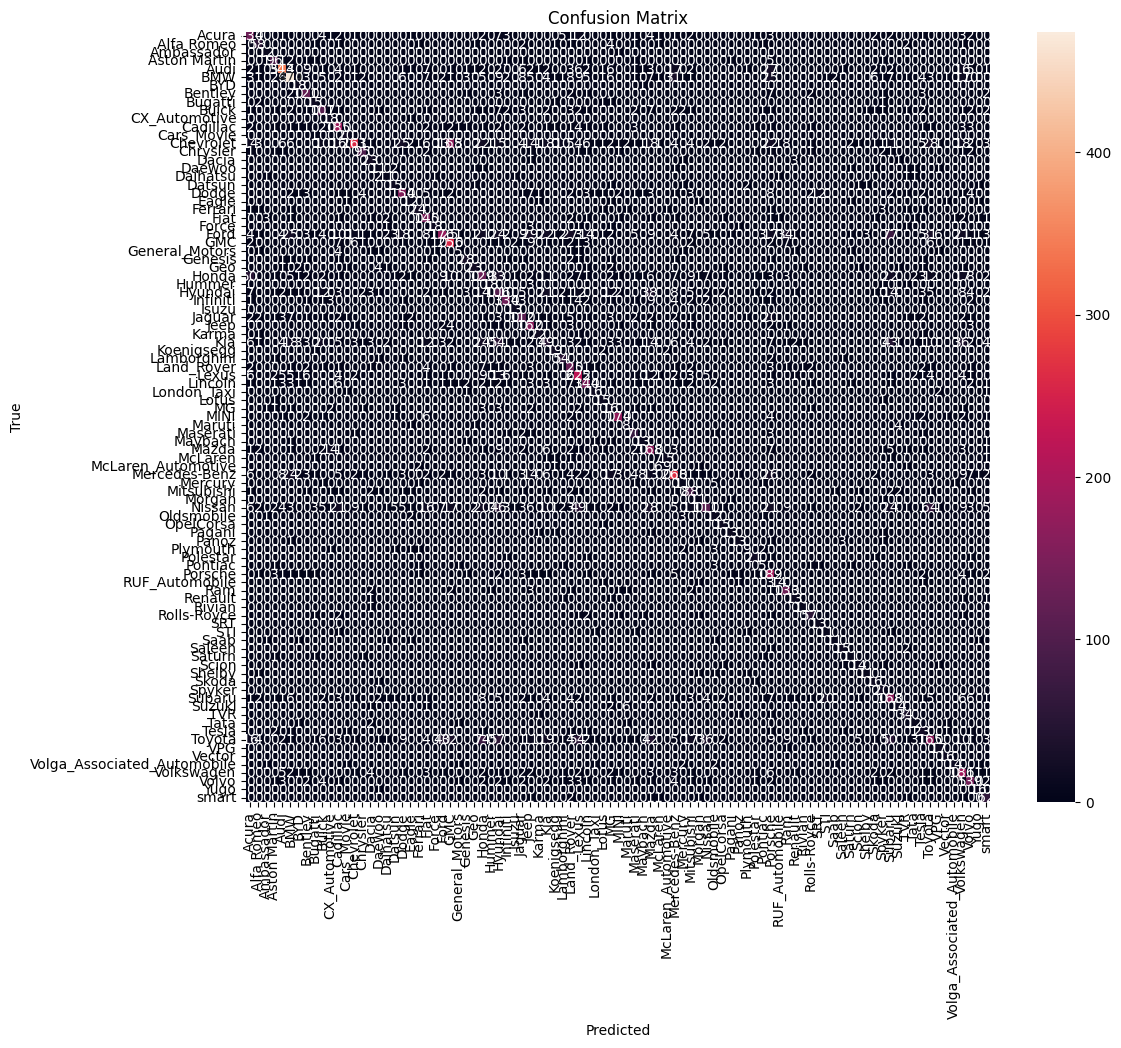

In [29]:
# Test the model

print("\nEvaluating on test set...")
model.eval()
correct = 0
total = 0
test_start = time.time()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Extract logits from outputs if needed - Hugging Face models return objects with logits attribute
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_time = time.time() - test_start
print(f"Test completed in {test_time:.2f} seconds")
print("Unique labels:", np.unique(all_labels))
print("Unique predictions:", np.unique(all_preds))
#print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Print final DirectML device information
print("\nDirectML GPU Usage Information:")
print(f"Device Name: {dml.device_name(dml.default_device())}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test 1

Loading model...


C:\Users\lalad\AppData\Local\Temp\ipykernel_16684\1939632613.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./best_resnet_car_classifier.pth'


Testing with a random image:
Selected image: P5J8QMV5UA90.jpg


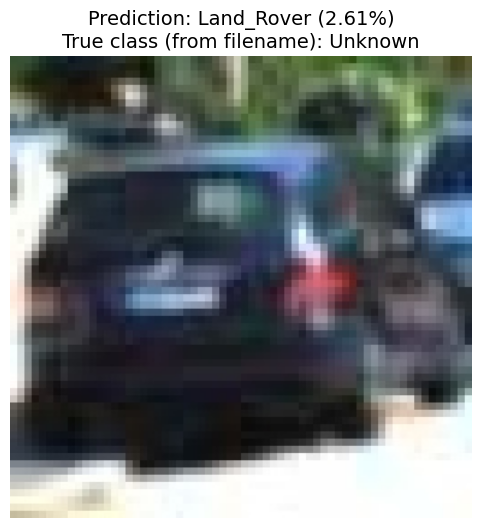

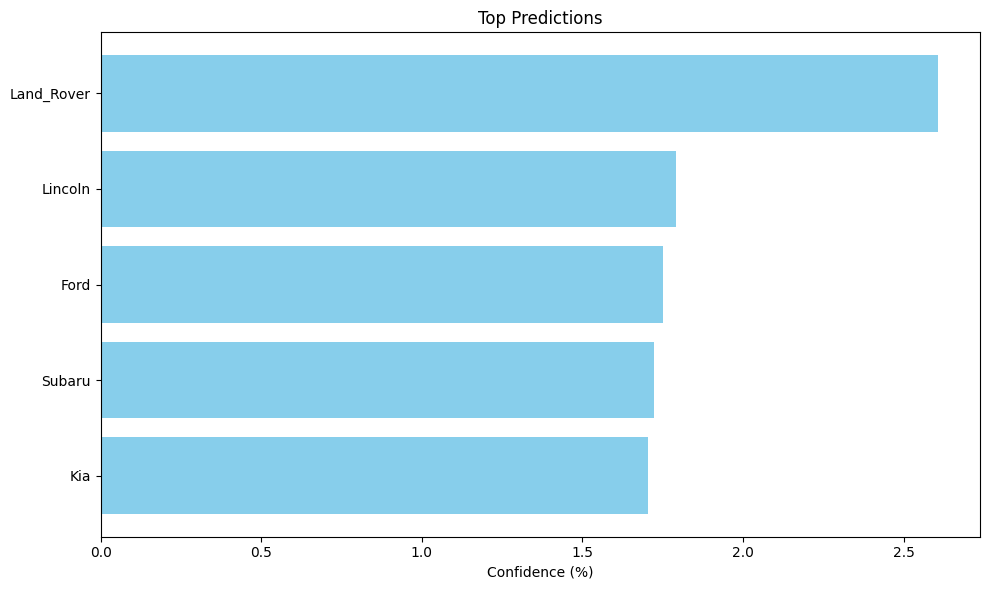


Testing with multiple random images:
Class names length: 93
Model output size: 93


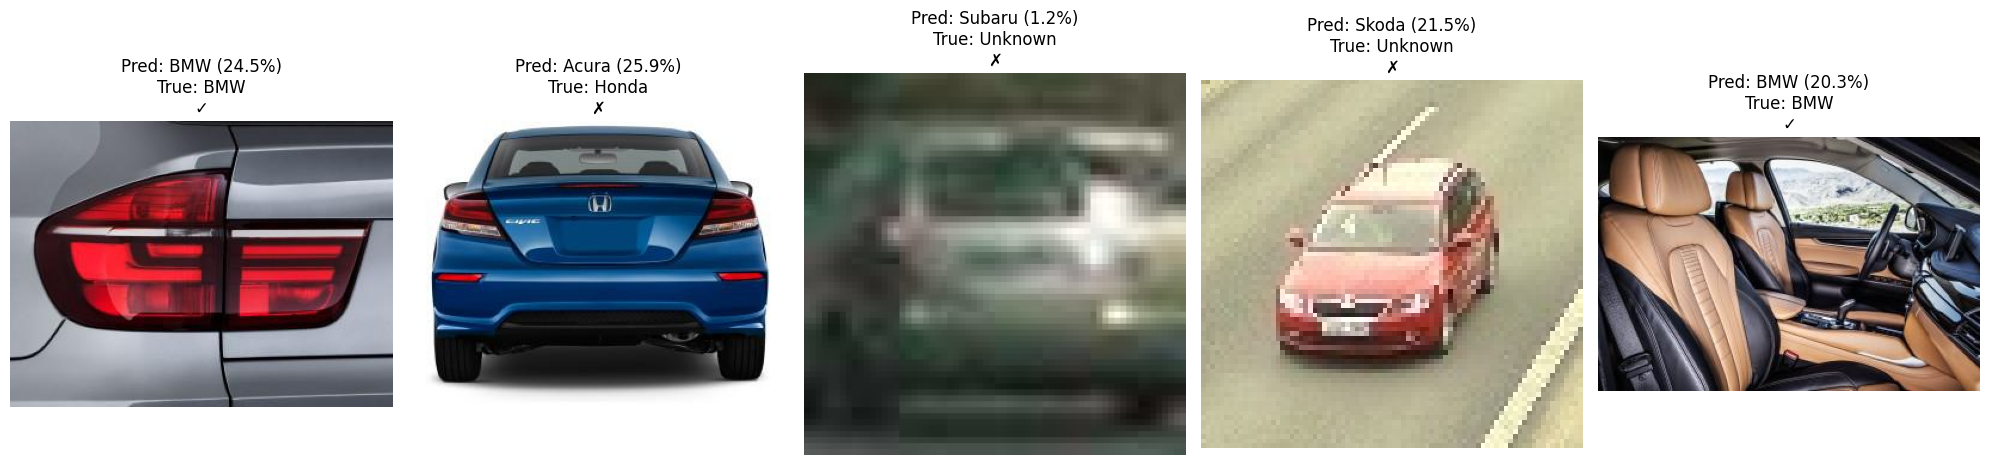

In [161]:
def test_with_random_image(model, class_names, device, data_dir='./images/cars', test_transform=None):
    """Test the model with a random car image"""
    # Get a random image from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    img_file = random.choice(image_files)
    img_path = os.path.join(data_dir, img_file)
    print(f"Selected image: {img_file}")
    
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Try to determine true label from filename
    true_class = "Unknown"
    for make in top_makes:
        if make.lower() in img_file.lower():
            true_class = make
            break
    
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        # Extract logits from output object
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
        probs = torch.nn.functional.softmax(logits, dim=1)[0]
        _, pred_idx = torch.max(logits, 1)
    
    # Get prediction results
    pred_class = class_names[pred_idx.item()]
    confidence = probs[pred_idx.item()].item() * 100
    
    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)\nTrue class (from filename): {true_class}", fontsize=14)
    plt.show()
    
    # Get top 5 predictions
    top_k = min(5, len(class_names))
    top_probs, top_idx = torch.topk(probs, top_k)
    top_classes = [class_names[idx.item()] for idx in top_idx]
    top_confidences = [prob.item() * 100 for prob in top_probs]
    
    # Show top predictions
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_k), top_confidences, color='skyblue')
    plt.yticks(range(top_k), top_classes)
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    plt.gca().invert_yaxis()  # Highest confidence at the top
    plt.tight_layout()
    plt.show()
    
    return pred_class, confidence, true_class

# Test multiple random images
def test_multiple_random_images(model, class_names, device, data_dir='./images/cars', 
                               test_transform=None, num_images=5):
    """Test model with multiple random images with error handling for class index mismatches"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Check model output size vs class_names
    print(f"Class names length: {len(class_names)}")
    # Check model output size by getting the final layer's output dimension
    output_size = None
    if hasattr(model, 'fc'):
        if isinstance(model.fc, nn.Sequential):
            # Find the Linear layer within Sequential
            for layer in model.fc:
                if isinstance(layer, nn.Linear):
                    output_size = layer.out_features
                    break
        elif hasattr(model.fc, 'out_features'):
            output_size = model.fc.out_features
    
    print(f"Model output size: {output_size}")
    if output_size and output_size != len(class_names):
        print(f"WARNING: Model output size ({output_size}) doesn't match class_names length ({len(class_names)})")
        print("This will cause index errors when predictions are out of range")
    
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(random_images), figsize=(20, 5))
    if len(random_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Try to determine true class
        true_class = "Unknown"
        for make in top_makes:
            if make.lower() in img_file.lower():
                true_class = make
                break

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details for debugging
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range for class_names list (length {len(class_names)})")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        correct = "✓" if pred_class.replace('_', ' ') == true_class else "✗"
        axes[i].set_title(f"Pred: {pred_class} ({confidence:.1f}%)\nTrue: {true_class}\n{correct}")
        
        results.append((pred_class, confidence, true_class))
    
    plt.tight_layout()
    plt.show()
    return results

# Load the trained model
print("Loading model...")
checkpoint = torch.load('./best_resnet_car_classifier.pth')
#num_classes = 48  # As indicated by the error message - the checkpoint has 48 classes
#model = models.resnext101_32x8d(weights='IMAGENET1K_V2')
model = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, len(class_names)),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)
model.load_state_dict(torch.load('./best_resnet_car_classifier.pth'))

# Test with a single random image
print("\nTesting with a random image:")
pred_class, confidence, true_class = test_with_random_image(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid']
)

# Test with multiple random images
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    num_images=5
)

test 2


Testing with multiple random images:
Class names length: 93
Model output size: 93


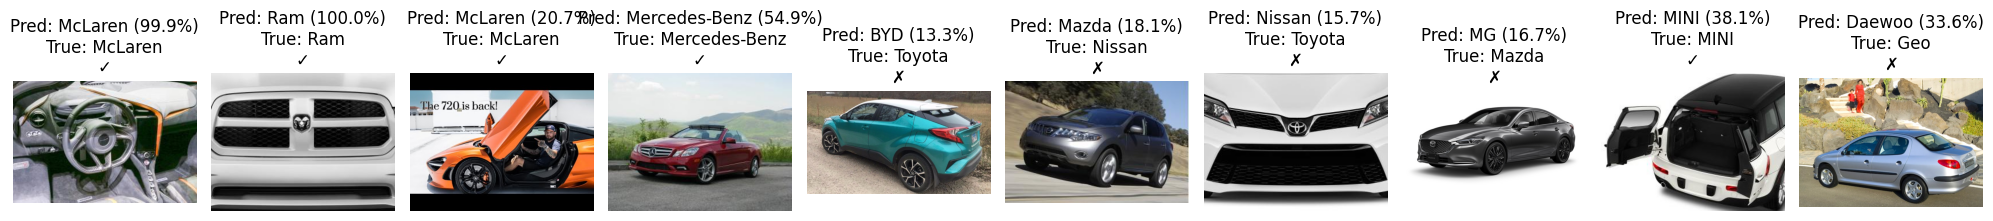

In [159]:
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    num_images=10,
    data_dir='./images/cars2'
)


Testing with multiple random named images:
Class names length: 93
Model output size: 93


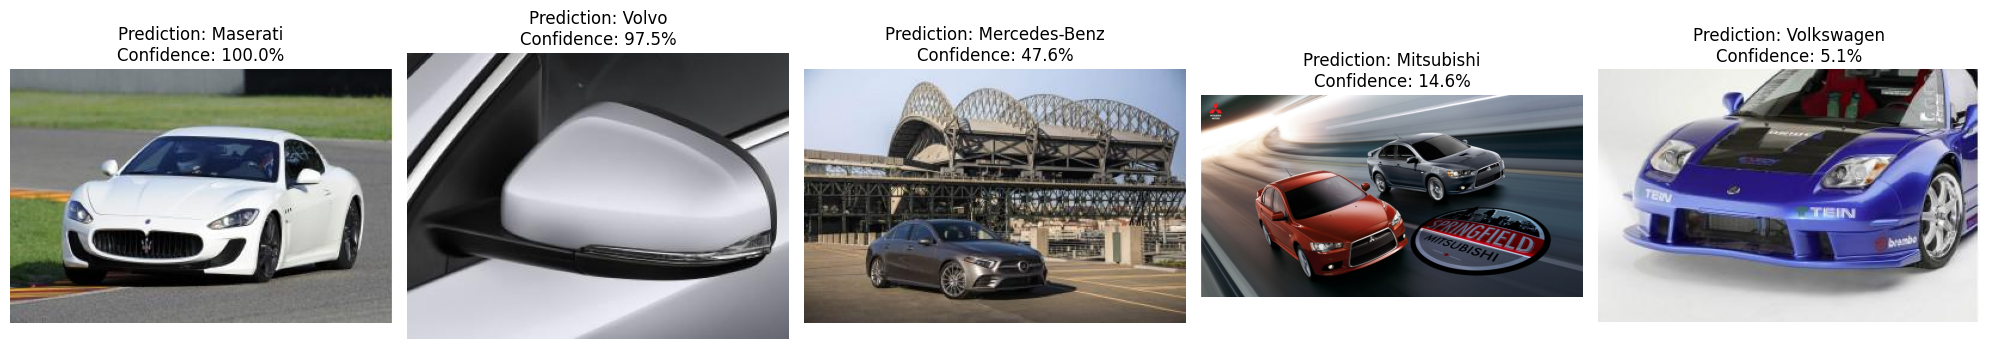

In [162]:
def test_multiple_random_named_images(model, class_names, device, data_dir='./images/cars', 
                               test_transform=None, num_images=5):
    """Test model with multiple random images without using filenames for true class"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Check model output size vs class_names
    print(f"Class names length: {len(class_names)}")
    # Check model output size by getting the final layer's output dimension
    output_size = None
    if hasattr(model, 'fc'):
        if isinstance(model.fc, nn.Sequential):
            # Find the Linear layer within Sequential
            for layer in model.fc:
                if isinstance(layer, nn.Linear):
                    output_size = layer.out_features
                    break
        elif hasattr(model.fc, 'out_features'):
            output_size = model.fc.out_features
    
    print(f"Model output size: {output_size}")
    if output_size and output_size != len(class_names):
        print(f"WARNING: Model output size ({output_size}) doesn't match class_names length ({len(class_names)})")
        print("This will cause index errors when predictions are out of range")
    
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(random_images), figsize=(20, 5))
    if len(random_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Completely disregard filename - set true class as unknown or N/A
        true_class = "N/A"  # Not using filename for true class

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details for debugging
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range for class_names list (length {len(class_names)})")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Display image with prediction (without comparing to true class since we're ignoring it)
        axes[i].imshow(image)
        axes[i].axis('off')
        # Remove the checkmark since we have no true class to compare with
        axes[i].set_title(f"Prediction: {pred_class}\nConfidence: {confidence:.1f}%")
        
        results.append((pred_class, confidence, true_class))
    
    plt.tight_layout()
    plt.show()
    return results



print("\nTesting with multiple random named images:")
results = test_multiple_random_named_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    num_images=5,
    data_dir='./images/cars'
)

### TESTED IMAGES WITH A CONFIDENCE OF THE PREDICTION ABOVE 60%

Processing 30 images to find high confidence predictions...


100%|██████████| 30/30 [00:00<00:00, 69.61it/s]


Found 11 images with confidence >= 50.0%


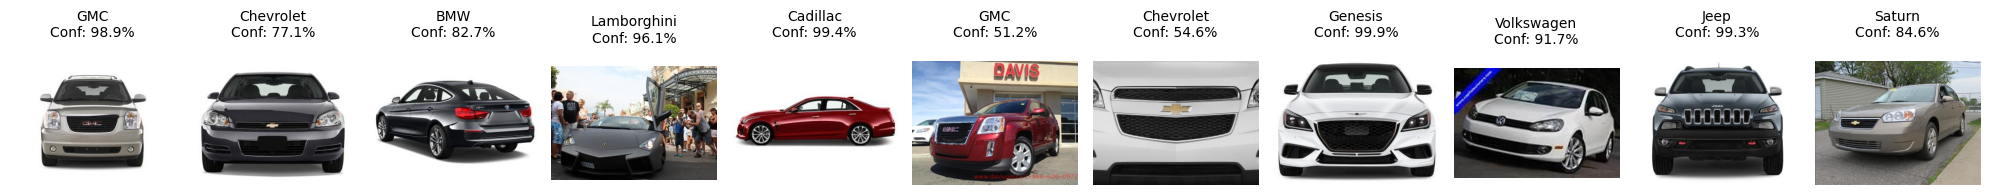

In [165]:
def test_high_confidence_images(model, class_names, device, data_dir='./images/cars', 
                              test_transform=None, min_confidence=60.0, num_samples=50):
    """Test model with random images but only display those with high confidence predictions"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Sample more images than we'll likely display to ensure we find enough high confidence ones
    random_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Store high confidence results
    high_confidence_results = []
    
    # Process each image and find high confidence predictions
    print(f"Processing {len(random_images)} images to find high confidence predictions...")
    for img_file in tqdm(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        try:
            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)
        
            with torch.no_grad():
                outputs = model(img_tensor)
                # Extract logits from output object
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                _, pred_idx = torch.max(logits, 1)
                
                # Get prediction details
                predicted_index = pred_idx.item()
                confidence = probs[predicted_index].item() * 100
                
                # Only keep high confidence predictions
                if confidence >= min_confidence:
                    pred_class = class_names[predicted_index]
                    high_confidence_results.append((image, pred_class, confidence, img_file))
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
    
    # Display results
    if not high_confidence_results:
        print(f"No predictions with confidence >= {min_confidence}% found.")
        return []
    
    print(f"Found {len(high_confidence_results)} images with confidence >= {min_confidence}%")
    
    # Create figure with subplots for high confidence predictions
    fig, axes = plt.subplots(1, len(high_confidence_results), figsize=(20, 5))
    if len(high_confidence_results) == 1:
        axes = [axes]
    
    # Process each high confidence result
    for i, (image, pred_class, confidence, img_file) in enumerate(high_confidence_results):
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"{pred_class}\nConf: {confidence:.1f}%\n", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    return high_confidence_results

# Run the function
high_conf_results = test_high_confidence_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['valid'],
    min_confidence=50.0,  # 60% minimum confidence
    num_samples=30  # Process 30 random images
)

____

### WORK IN PROGRESS TRAINING WITH RANDOMIZED NAMES OF IMAGES

In [ ]:
def organize_random_car_images(source_dir, output_dir, model, transform, class_names, 
                              confidence_threshold=0.7, copy_instead_of_move=True):
    """
    Auto-organize random car images using trained model predictions
    
    Args:
        source_dir: Directory containing random car images (e.g., './images/cars')
        output_dir: Directory to organize images into class folders (e.g., './organized_cars')
        model: Trained car classification model
        transform: Image transformation pipeline
        class_names: List of class names (car makes)
        confidence_threshold: Minimum confidence to assign a class
        copy_instead_of_move: If True, copy images; if False, move them
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create class directories
    for class_name in class_names:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)
    
    # Get all images from source directory
    image_files = [f for f in os.listdir(source_dir) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Found {len(image_files)} images in {source_dir}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Track results
    results = {
        'processed': 0,
        'organized': 0,
        'low_confidence': 0,
        'errors': 0,
        'class_distribution': {}
    }
    
    # Process each image
    for img_file in tqdm(image_files, desc="Classifying car images"):
        try:
            img_path = os.path.join(source_dir, img_file)
            results['processed'] += 1
            
            # Load and preprocess the image
            image = Image.open(img_path).convert('RGB')
            img_tensor = transform(image).unsqueeze(0).to(device)
            
            # Get model prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                probs = torch.nn.functional.softmax(logits, dim=1)[0]
                conf_val, pred_idx = torch.max(probs, 0)
                
                confidence = conf_val.item()
                pred_class = class_names[pred_idx.item()]
                
            # If confidence meets threshold, organize the image
            if confidence >= confidence_threshold:
                # Update class distribution counter
                results['class_distribution'][pred_class] = \
                    results['class_distribution'].get(pred_class, 0) + 1
                
                # Destination path
                dst_path = os.path.join(output_dir, pred_class, img_file)
                
                # Copy or move the file
                if copy_instead_of_move:
                    shutil.copy2(img_path, dst_path)  # copy2 preserves metadata
                else:
                    shutil.move(img_path, dst_path)
                
                results['organized'] += 1
            else:
                results['low_confidence'] += 1
                
        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")
            results['errors'] += 1
    
    # Print results
    print("\nClassification Results:")
    print(f"Total images processed: {results['processed']}")
    print(f"Images organized: {results['organized']} ({results['organized']/results['processed']*100:.1f}%)")
    print(f"Low confidence images: {results['low_confidence']} ({results['low_confidence']/results['processed']*100:.1f}%)")
    print(f"Errors: {results['errors']} ({results['errors']/results['processed']*100:.1f}%)")
    
    # Print class distribution
    print("\nClass Distribution:")
    for class_name, count in sorted(results['class_distribution'].items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{class_name}: {count} images")
    
    return results, output_dir

In [ ]:
# Use your best model
model.load_state_dict(torch.load('./best_resnet_car_classifier.pth'))
model.eval()

# Organize random car images
results, organized_dir = organize_random_car_images(
    source_dir='./images/cars',           # Your single folder with random car images
    output_dir='./organized_cars',        # Where to place organized images
    model=model,
    transform=data_transforms['test'],    # Use your test transforms
    class_names=class_names,
    confidence_threshold=0.6,             # Adjust based on model performance
    copy_instead_of_move=True             # Keep originals
)

In [ ]:
# Create datasets from organized images
new_datasets = create_image_datasets('./organized_cars', data_transforms)

# Update your dataloaders
new_dataloaders = {
    'train': DataLoader(new_datasets['train'], batch_size=16, shuffle=True, num_workers=4),
    'valid': DataLoader(new_datasets['valid'], batch_size=16, shuffle=False, num_workers=4) if new_datasets['valid'] is not None else None,
    'test': DataLoader(new_datasets['test'], batch_size=16, shuffle=False, num_workers=4) if new_datasets['test'] is not None else None,
}

# Use a lower learning rate for fine-tuning
learning_rate = 0.001  # 10x smaller than initial rate

# Update global variables
dataloaders = new_dataloaders
class_names = new_datasets['train'].classes
num_classes = len(class_names)

# Fine-tune model
train_with_progressive_unfreezing(num_epochs=20, accumulation_steps=2)